# Initialization

## Drive Mount

In [ ]:
#Google Drive + Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Libs

In [ ]:
#Bibliotecas
#https://ieeexplore.ieee.org/document/10064297
#Numpy
import numpy as np
#Mayplotlib
import matplotlib.pyplot as plt
#Operating System
import os as os
#System
import sys
#Scipy
import scipy.io as sio
#Pandas
import pandas as pd
#TensorFlow
import tensorflow as tf
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
#Keras
from keras.utils import np_utils
from keras.optimizers import Adam
#Libs for CNN Modelling
import time
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D

## GPU

In [ ]:
# Find out NVIDIA GPU model (randomly assigned by Colab)
# Deep learning performance: K80 < P4 < T4 < P100
# https://ai-benchmark.com/ranking_deeplearning.html
!python -V
gpu = !nvidia-smi -L
gpu = gpu[0].split(' (')[0]
if 'failed' in gpu:
  print('GPU: None')
else:
  print(gpu, '\n')
  # GPU information
  !nvidia-smi'

Python 3.10.12
GPU 0: Tesla T4 

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


# Global

In [ ]:
#Variáveis Globais

#Qual o diretório principal?
dataRoot = 'drive/MyDrive/Colab Notebooks/HSI_CNN'
#Qual o diretório de dados
dataDir = dataRoot+'/Data/HSI'

#Qual o dataset a ser usado
##IP -- Indian Pines
##SA -- Salinas
##PU -- PaviaU
dataset = 'PU'

#Normalizar dados?
normalizeData = False

#Nome do Modelo
TF_MODEL = dataset + "_CNN"
TF_MODEL_TFL = dataset + "_CNN.tflite"
TF_MODEL_C = dataset + "_CNN.h"

#Quantidade de dados que devem ser colocados no treino
test_ratio = 0.15 #0.3
#Parte da base de teste que vai para validação
valid_ratio = 0.5 #0.2


# Data Prep

## Load

In [ ]:
def loadData(input_str):
  """
    Retorna uma base de dados com suas labels

    Argumentos:
    input_str -- O nome do dataset a ser considerado podendo ser:
      IP -- Indian Pines
      SA -- Salinas
      PU -- PaviaU

    Retorno:
    (data, labels)
  """
  data_path = os.path.join(os.getcwd(),dataDir)
  if input_str == "IP":
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
  elif input_str == "SA":
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
  elif input_str == "PU":
      data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
      labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
  else:
    raise ValueError("Entrada inválida. Por favor, insira IP, SA ou PU.")
  return data, labels

#Carregando dados em 'X' e labels em 'y'
X_load, y_load = loadData(dataset)

In [ ]:
X_load.shape

(610, 340, 103)

## Reshape for Pixel

In [ ]:
def removeBackground(X, y):
  """
  Remove todas as amostras de "fundo/background", ou seja, as amostras com classe==0.
  """
  X, y = X[y>0,:], y[y>0]
  y -= 1
  return X, y

X_re1 = X_load.copy()
y_re1 = y_load.copy()

#Dando 'reshape' para criar um array 1D com N bandas - Transformação para classificação por pixel
X_re2 = X_re1.reshape([X_re1.shape[0]*X_re1.shape[1],X_re1.shape[2]])
y_re2 = y_re1.reshape([y_re1.shape[0]*y_re1.shape[1]])

#Filtrando(tirando) algumas bandas do dataset
X_re, y_new = removeBackground(X_re2,y_re2)

print("Reshape to create a 1D array of N bands - Trasform to classify by pixels (init): ", X_re1.shape, y_re1.shape)
print("Reshape to create a 1D array of N bands - Trasform to classify by pixels (reshaped): ", X_re2.shape, y_re2.shape)
print("Reshape to create a 1D array of N bands - Trasform to classify by pixels (reshaped and filtered): ", X_re.shape, y_new.shape)

#Count samples per class
print("\nSample quantity per class in train dataset:\n", pd.DataFrame(y_new)[0].value_counts())

#Aqui poderá ser feito um balanceamento também, caso haja necessidade.

Reshape to create a 1D array of N bands - Trasform to classify by pixels (init):  (145, 145, 200) (145, 145)
Reshape to create a 1D array of N bands - Trasform to classify by pixels (reshaped):  (21025, 200) (21025,)
Reshape to create a 1D array of N bands - Trasform to classify by pixels (reshaped and filtered):  (10249, 200) (10249,)

Sample quantity per class in train dataset:
 10    2455
1     1428
13    1265
9      972
2      830
5      730
11     593
4      483
7      478
14     386
3      237
12     205
15      93
0       46
6       28
8       20
Name: 0, dtype: int64


## Normalize and PCA

In [ ]:
#Sequencia ideial:
#Normalizar -> PCA -> Quantizar
#Obs: Possivelmente a normalização seja problemática devido aos outliers dos dados

def applyNormalize(data):
  """
  Aplica o método de Normalização
  """
  # Normalize data
  mean = np.mean(data)
  std = np.std(data)
  normalized_data = (data - mean) / std
  print("\nData normalized")
  print("Normalized data shape:", normalized_data.shape, "\nExample:")
  print(normalized_data[0])
  return normalized_data

def applyPCA(X, nBands=75):
  """
  Aplica o método Principal Component Analysis
  Reduz a quantidade de bandas para nBands, levando em consideração as mais importantes.
  """
  #Número de bandas em um único pixel
  print("\nNumber of bands in a single pixel: ", X.shape[1])
  # Create a PCA object with nBands components
  model = PCA(n_components=nBands, whiten=True, random_state=42)
  # Fit the PCA model to the data
  model.fit(X)
  # Transform the data using the PCA model
  print("PCA - Old data shape:", X.shape, " - ", X.dtype)
  print(X[0])
  X_out = model.transform(X)
  print("\nPCA - Transformed data shape:", X_out.shape, " - ", X_out.dtype)
  print("Number of bands in a single pixel after PCA: ", X_out.shape[1])
  print("Example:")
  print(X_out[0])
  return X_out, model

####Normalize
X_norm = X_re.copy()
if(normalizeData):
  X_norm = applyNormalize(X_norm)
else:
  print("\nNo normalization")

####PCA
#PCA reduz a quantidade de banda (Principal Component Analysis)
#Para a base Indian Pines número de bandas será 30 para a restante 15
Kb = 30 if dataset == 'IP' else 15
X_pca, pca_model = applyPCA(X_norm, nBands=Kb)
X_new = X_pca.copy()

####Quantize -> Legacy
#X_new = applyQuantize_i8(X_new)


'''
def applyQuantize_i8(X):
  def get_int_value(float_value):
    k = quant_scale
    q = quant_zero_point
    return np.round((float_value / k) - q).astype(np.int8)
  X[:, :] = np.vectorize(get_int_value)(X[:, :])
  X = X.astype(np.int8)
  print("\nData quantized")
  print("Quantazied data shape:", X.shape, "\nExample:")
  print(X[0])
  return X

def applyQuantize_i8_2(data):
  # Initialize the quantization parameters
  quant_min = -128
  quant_max = 127
  data_qtz = np.empty_like(data, dtype=np.int8)
  #
  for i in range(data.shape[1]):
    data_qtz[:, i] = np.clip(np.round(data[:, i] * quant_max), quant_min, quant_max)
  print("\nData quantized")
  print("Quantized data shape:", data_qtz.shape, "\nExample:")
  print(data_qtz[0])
  return data_qtz

def applyQuantize_f16(input_data):
  input_data = input_data.astype(np.float16)
  return input_data

#Quantizar dados?
#-> 0   == Não
#-> i8  == int8
#-> f16 == float16
if(quantizeInputData == "i8"):
  X_new = applyQuantize_i8(X_new)
  print("Xtype: ", X_new.dtype)
elif(quantizeInputData == "f16"):
  X_new = applyQuantize_f16(X_new)
  print("Xtype: ", X_new.dtype)
else:
  print("\nNo X quantization")
  print("X dtype: ", X_new.dtype)
'''


No normalization

Number of bands in a single pixel:  200
PCA - Old data shape: (10249, 200)  -  uint16
[3172 4142 4506 4279 4782 5048 5213 5106 5053 4750 4816 4769 4610 4805
 4828 4861 4767 4624 4549 4463 4462 4446 4445 4336 4381 4319 4207 4305
 4311 3991 4168 3942 4061 4362 4318 4252 4869 5284 5055 3591 5175 5217
 5058 4969 4721 4291 4555 4886 4868 4806 4783 4811 4709 3903 3795 3715
 2591 2130 2269 2480 3145 3626 4060 4296 4211 4225 4157 4133 4082 4048
 3935 3843 3784 3642 3271 2707 1707 1564 1838 1719 2229 2764 2919 2873
 2977 2913 3034 3051 3124 3101 3033 2713 2740 2947 2706 2834 2856 2683
 2400 2229 1822 1542 1097 1047 1069 1100 1122 1259 1365 1261 1374 1630
 1851 2028 2130 2170 2205 2214 2204 2100 2106 2146 2089 2078 2134 2127
 2074 2057 2045 2003 1999 1959 1924 1883 1843 1781 1716 1698 1645 1540
 1410 1294 1131 1044 1032 1045 1100 1212 1295 1244 1100 1103 1216 1346
 1330 1259 1251 1313 1372 1393 1402 1396 1381 1396 1381 1353 1346 1341
 1332 1324 1310 1318 1330 1310 1292 1280 12

'\ndef applyQuantize_i8(X):\n  def get_int_value(float_value):\n    k = quant_scale\n    q = quant_zero_point\n    return np.round((float_value / k) - q).astype(np.int8)\n  X[:, :] = np.vectorize(get_int_value)(X[:, :])\n  X = X.astype(np.int8)\n  print("\nData quantized")\n  print("Quantazied data shape:", X.shape, "\nExample:")\n  print(X[0])\n  return X\n\ndef applyQuantize_i8_2(data):\n  # Initialize the quantization parameters\n  quant_min = -128\n  quant_max = 127\n  data_qtz = np.empty_like(data, dtype=np.int8)\n  #\n  for i in range(data.shape[1]):\n    data_qtz[:, i] = np.clip(np.round(data[:, i] * quant_max), quant_min, quant_max)\n  print("\nData quantized")\n  print("Quantized data shape:", data_qtz.shape, "\nExample:")\n  print(data_qtz[0])\n  return data_qtz\n\ndef applyQuantize_f16(input_data):\n  input_data = input_data.astype(np.float16)\n  return input_data\n\n#Quantizar dados?\n#-> 0   == Não\n#-> i8  == int8\n#-> f16 == float16\nif(quantizeInputData == "i8"):\n  X_n

## Reshape for CNN

In [ ]:
#Será utilizado no modelo NN, basicamente o modelo necessita de um 'shape' específico
print("Reshape input data - Previous: ", X_new.shape)
X_new = X_new.reshape(-1, Kb, 1)
print("Reshape input data - After: ", X_new.shape)
#X_new = np.expand_dims(X_new, axis=-1)
#print("Reshape input data - After2: ", X_new.shape, " Type: ", X_new.dtype)

#X_new = X_new[:, :, np.newaxis]
#X_new = X_new.astype(np.float32)

Reshape input data - Previous:  (10249, 30)
Reshape input data - After:  (10249, 30, 1)


## Split Base

In [ ]:
#Separar a base de treino e de teste+validacao do Dataset
#Stratify: Proportion of samples from each class is maintained in both the training and testing
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_new, y_new, test_size=test_ratio, random_state=42,stratify=y_new)

#(One-hot encoding) Precisamos deixar em um 'vetor de bits' devido a função de perda loss='categorical_crossentropy'
#y_train = np_utils.to_categorical(y_train).astype(np.float16)
#y_val_and_test = np_utils.to_categorical(y_val_and_test).astype(np.float16)
#if(quantizeInputData == "i8"):
#  y_train = np_utils.to_categorical(y_train).astype(np.int8)
#  y_val_and_test = np_utils.to_categorical(y_val_and_test).astype(np.int8)
#else:

y_train = np_utils.to_categorical(y_train)
y_val_and_test = np_utils.to_categorical(y_val_and_test)


#Separar a base de teste e de validação do Dataset
X_test, X_val, y_test, y_val = train_test_split(X_val_and_test, y_val_and_test, test_size=valid_ratio, random_state=42, stratify=y_val_and_test)

#Quantidade de amostras por classe na base de TREINO
#print("\nSample quantity per class in train dataset:\n", pd.DataFrame(y_train)[0].value_counts())
#Quantidade de amostras por classe na base de TESTE
#print("\nSample quantity per class in test dataset:\n", pd.DataFrame(y_validate_test)[0].value_counts())
#Quantidade de amostras por classe na base de VALIDACAO
#print("\nSample quantity per class in validation dataset:\n", pd.DataFrame(y_val)[0].value_counts())

print("Original - X_new:", X_new.shape, " |", X_new.dtype)
print("Reshape - X_train:", X_train.shape, " |", X_train.dtype)
print("Reshape - X_test:", X_test.shape, " |", X_test.dtype)
print("Reshape - X_validation:", X_val.shape, " |", X_val.dtype)
print("\nOriginal - y_new:", y_new.shape, " |", y_new.dtype)
print("Reshape - y_train:", y_train.shape, " |", y_train.dtype)
print("Reshape - y_test:", y_test.shape, " |", y_test.dtype)
print("Reshape - y_validation:", y_val.shape, " |", y_val.dtype)

#Pegando informações para a CNN
channels, size, classes = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print("\nChannels:", channels, "\nSize: ", size, "\nClasses: ", classes)

Original - X_new: (10249, 30, 1)  | float64
Reshape - X_train: (8711, 30, 1)  | float64
Reshape - X_test: (769, 30, 1)  | float64
Reshape - X_validation: (769, 30, 1)  | float64

Original - y_new: (10249,)  | uint8
Reshape - y_train: (8711, 16)  | float32
Reshape - y_test: (769, 16)  | float32
Reshape - y_validation: (769, 16)  | float32

Channels: 30 
Size:  1 
Classes:  16


# CNN

##Modelling

In [ ]:
#CNN function
def make_cnn_1D():
  model = Sequential()
  model.add(keras.layers.Input(shape=(channels,size)))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model.add(Conv1D(filters=16, kernel_size=9, activation='relu')) #7  #9 # Convolutional 1D
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) #5  #7 # Convolutional 1D
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) #3  #5 # Convolutional 1D
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) #3  #2 # Convolutional 1D
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu')) #fully connected layers with 128 neurons and ReLU activation function
  model.add(Dropout(0.5)) #old 0.3
  model.add(Dense(units=64, activation='relu')) #fully connected layers with 64 neurons and ReLU activation function
  model.add(Dropout(0.5)) #old 0.3
  model.add(Dense(classes, activation='softmax')) #fully connected layers with 64 neurons and softmax activation function

  adam = Adam(learning_rate=0.001, decay=1e-06)

  #Compiling the CNN Model
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model
#####

#CNN function
def make_cnn_2D():
  model = Sequential()
  model.add(keras.layers.Input(shape=(channels,size,1)))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model.add(Conv2D(filters=16, kernel_size=(9,1), activation='relu')) #7  #9 # Convolutional 2D
  model.add(Conv2D(filters=32, kernel_size=(3,1), activation='relu')) #5  #7 # Convolutional 2D
  model.add(Conv2D(filters=64, kernel_size=(3,1), activation='relu')) #3  #5 # Convolutional 2D
  model.add(Conv2D(filters=64, kernel_size=(3,1), activation='relu')) #3  #2 # Convolutional 2D
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu')) #fully connected layers with 128 neurons and ReLU activation function
  model.add(Dropout(0.5)) #old 0.3
  model.add(Dense(units=64, activation='relu')) #fully connected layers with 64 neurons and ReLU activation function
  model.add(Dropout(0.5)) #old 0.3
  model.add(Dense(classes, activation='softmax')) #fully connected layers with 64 neurons and softmax activation function

  adam = Adam(learning_rate=0.001, decay=1e-06)

  #Compiling the CNN Model
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

#Model to be create - CNN 1D - IP
model = make_cnn_2D()

#Salvando o modelo
model.save(TF_MODEL)
model.save("modelo.h5")
print("Original - X_new:", X_new.shape, " |", X_new.dtype)
print(model.summary())

Original - X_new: (10249, 30, 1)  | float64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 1, 16)         160       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 1, 32)         1568      
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 1, 64)         6208      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 1, 64)         12352     
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dr

## Train

In [ ]:
start_time = time.time()#Inicinado tempo
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
NUM_EPOCHS = 60 #qtt of epochs
BATCH_SIZE = 64 #batch_size
#Training/Fitting the CNN Model
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val, y_val), callbacks=[early_stopping])#, class_weight = class_weights, shuffle=True )
end_time = time.time()#Parando tempo
print("Time spent to train: ", end_time-start_time)

Epoch 1/60
137/137 [==============================] - 3s 17ms/step - loss: 2.0803 - accuracy: 0.3414 - val_loss: 1.2908 - val_accuracy: 0.5787
Epoch 2/60
137/137 [==============================] - 2s 15ms/step - loss: 1.3644 - accuracy: 0.5395 - val_loss: 0.9955 - val_accuracy: 0.6229
Epoch 3/60
137/137 [==============================] - 3s 22ms/step - loss: 1.1784 - accuracy: 0.5917 - val_loss: 0.8903 - val_accuracy: 0.6905
Epoch 4/60
137/137 [==============================] - 2s 17ms/step - loss: 1.0696 - accuracy: 0.6255 - val_loss: 0.8234 - val_accuracy: 0.7165
Epoch 5/60
137/137 [==============================] - 2s 13ms/step - loss: 0.9772 - accuracy: 0.6656 - val_loss: 0.7814 - val_accuracy: 0.7269
Epoch 6/60
137/137 [==============================] - 2s 13ms/step - loss: 0.9272 - accuracy: 0.6763 - val_loss: 0.7402 - val_accuracy: 0.7386
Epoch 7/60
137/137 [==============================] - 2s 12ms/step - loss: 0.8761 - accuracy: 0.6919 - val_loss: 0.7042 - val_accuracy: 0.7386

## Plotting Loss

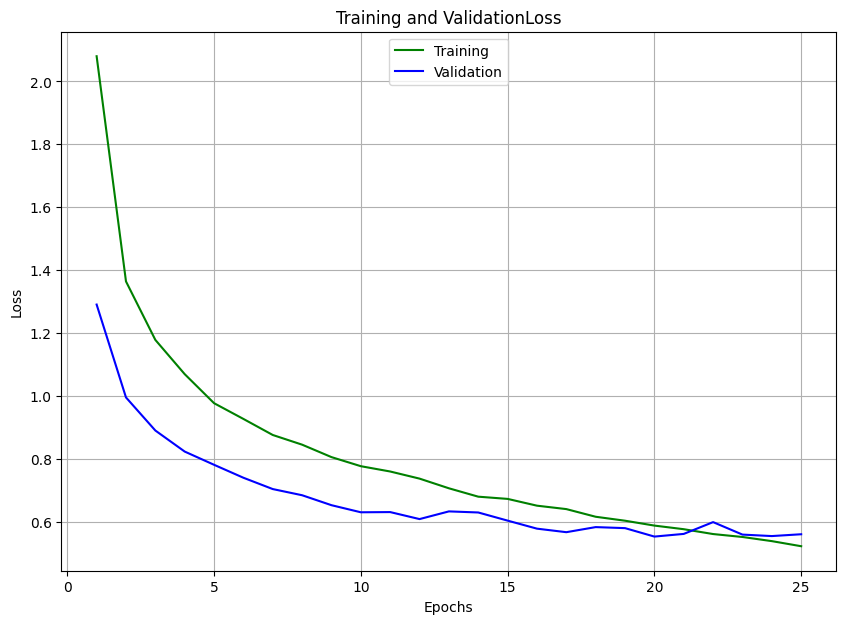

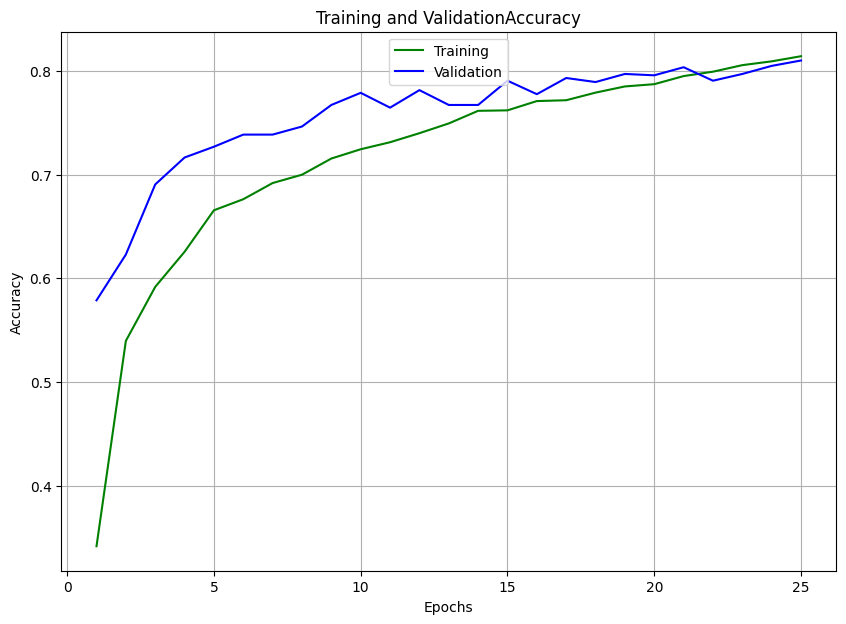

In [ ]:
#Loss function plot - Train and Validation
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, early_stopping.stopped_epoch + 1 + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend(['Training','Validation'], loc='upper center')
  plt.grid()
  plt.savefig(type_txt + "_curve_CNN.pdf")
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

## Predict

In [ ]:
start_time = time.time()#Inicinado tempo
prediction = model.predict(X_test)
predicted_class = np.argmax(prediction, axis=1) #Pegar indice máximo de cada Row
end_time = time.time()#Parando tempo
print("Time spent to predict: ", end_time-start_time)

25/25 [==============================] - 0s 3ms/step
Time spent to predict:  0.3105134963989258


## Results

In [ ]:
classification = classification_report(np.argmax(y_test, axis=1), predicted_class, zero_division=1)
print(classification)

#original_stdout = sys.stdout # Save a reference to the original standard output
#with open('result_CNN1D.txt', 'w') as f:
#    sys.stdout = f # Change the standard output to the file we created.
#    print(classification)
#    sys.stdout = original_stdout # Reset the standard output to its original value


###### VIEL (KAPPA):
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

oa = accuracy_score(np.argmax(y_test, axis=1), predicted_class)
confusion = confusion_matrix(np.argmax(y_test, axis=1), predicted_class)
each_acc, aa = AA_andEachClassAccuracy(confusion)
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), predicted_class)
score = model.evaluate(X_test, y_test, batch_size=32)
Test_Loss =  score[0]*100

print("OA:   ", oa)
print("AA:   ", aa)
print("kappa:", kappa)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.74      0.76      0.75       107
           2       0.80      0.65      0.71        62
           3       0.50      0.33      0.40        18
           4       0.97      0.89      0.93        36
           5       0.89      1.00      0.94        54
           6       1.00      1.00      1.00         2
           7       0.95      1.00      0.97        36
           8       1.00      0.50      0.67         2
           9       0.61      0.67      0.64        73
          10       0.81      0.84      0.83       184
          11       0.68      0.71      0.70        45
          12       0.88      1.00      0.94        15
          13       0.92      0.97      0.94        95
          14       0.82      0.48      0.61        29
          15       0.78      1.00      0.88         7

    accuracy                           0.80       769
   macro avg       0.82   

# Convert Model Int8

## Quantize Model

In [ ]:
##Quantização de faixa dinâmica pós-treinamento
#https://www.tensorflow.org/lite/performance/post_training_quant?hl=pt-br
##Quantização pós-treinamento
#https://www.tensorflow.org/lite/performance/post_training_quantization?hl=pt-br
##(ESCOLHIDA) Quantização inteira pós-treinamento
#https://www.tensorflow.org/lite/performance/post_training_integer_quant?hl=pt-br

##Devemos quantizar nosso modelo gerado por dois motivos:
#Fica infinitamenet mais leve para aportar para o microcontrolador (floating point fica muito pesado em MCUs)
#Consumo de energia muito menor do MCU

#The following steps show how to use the TFLite converter to quantize and produce a suitable model for microcontrollers:
#This step is commonly called generating a representative dataset, and it is essential to reduce the risk of an accuracy drop in the quantization
#Select a few hundred of samples randomly from the test dataset to calibrate the quantization
def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

def representative_data_gen_i8():
  for i_value in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
    #i_value_i8 = tf.dtypes.cast(i_value, tf.int8)
    #yield [i_value_i8]
    yield [i_value]

#Import the TensorFlow SavedModel directory into TensorFlow Lite Converter
#converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#Representative dataset: This is the representative dataset generated in the first step
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)

#Optimizations: This defines the optimization strategy to adopt
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Supported ops: This forces the adoption of only integer 8-bit operators during the conversion.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] #If our model has unsupported kernels, the conversion will not succeed.

#Inference input/output type: This adopts the 8-bit quantization format for the network's input and output
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
#Therefore, we will need to feed the ML model with the quantized input features to run the inference correctly.

#Convert the model to TensorFlow Lite file format (FlatBuffers) as save it as .tflite
tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


##Save Model

In [ ]:
#Save the converted model as .tflite:
open(TF_MODEL_TFL, "wb").write(tflite_model_quant)


#Convert the TFLiteLite model to a C-byte array with xxd:
#The conversion to a C-byte array is crucial because the .tflite format requires an library into our application to load the file from memory.
#The -i option: containing the TFLite model as an unsigned char array with many hexadecimal numbers
!apt-get update && apt-get -qq install xxd
!xxd -i $TF_MODEL_TFL > $TF_MODEL_C
!cat $TF_MODEL_C
!cp -v "$TF_MODEL_TFL" "/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models"
!cp -v "$TF_MODEL_C" "/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models"

#Most of MCUs dont have OS and native filesystem.
#Therefore, the C-byte array format allows us to integrate the model directly into the application.
#Another reason is the .tflite file does not allow keeping the weights in program memory. Every byte matters and SRAM has limited capacity,
#keeping the model in program memory is generally more memory efficient when the weights are constant.

## Quantize Input

In [ ]:
def get_quantization_parameters():
  interpreter = tf.lite.Interpreter(model_path=TF_MODEL_TFL)
  interpreter.allocate_tensors()

  # Load input and output details
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  qtz_scale = interpreter.get_input_details()[0]['quantization_parameters']['scales'][0]
  qtz_zero_point = interpreter.get_input_details()[0]['quantization_parameters']['zero_points'][0]
  qtz_zero_point = qtz_zero_point*-1
  return(qtz_scale,qtz_zero_point)

def get_int_value(float_value, qtz_scale, qtz_zero_point):
  return np.round((float_value / qtz_scale) - qtz_zero_point).astype(np.int8)

# Quantize inputs to be tensor
X_mic = X_test.copy()
qtz_scale, qtz_zero_point = get_quantization_parameters()
print("Quantization Scale: " + str(qtz_scale))
print("Quantization Zero Point: " + str(qtz_zero_point))
X_mic[:, :, 0, 0] = np.vectorize(get_int_value)(X_mic[:, :, 0, 0],qtz_scale,qtz_zero_point)
X_mic = X_mic.astype(np.int8)

Quantization Scale: 0.04612913
Quantization Zero Point: 25


##Interpreter

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_TFL)
interpreter.allocate_tensors()

# Load input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Print the details.
print("Input details:", input_details)
print("\n")
print("Output details:", output_details)
print("\n")

# Calculate the number of correct predictions
correct = 0
# Load correct output
y_test_correct = np.argmax(y_test.copy().astype(np.int8), axis=1)

for i_value in range(len(X_mic)):
  # Get Input Data
  input_data_int = np.expand_dims(X_mic[i_value], axis=0)

  # Set the input tensor value.
  interpreter.set_tensor(input_details['index'], input_data_int)

  # Invoke the interpreter.
  interpreter.invoke()

  # Get the output tensor value.
  output_data = interpreter.get_tensor(output_details['index'])
  output_max = np.argmax(output_data, axis = 1)

  # Confirm equality.
  if output_max == y_test_correct[i_value]:
    correct = correct +1

acc_geral = float(correct/len(X_mic))
print("\nNumber of correct predictions: ", correct)
print("\nOverall Accuracy of interpreter: ", acc_geral)

Input details: {'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([ 1, 30,  1,  1], dtype=int32), 'shape_signature': array([-1, 30,  1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.04612912982702255, -25), 'quantization_parameters': {'scales': array([0.04612913], dtype=float32), 'zero_points': array([-25], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


Output details: {'name': 'StatefulPartitionedCall:0', 'index': 24, 'shape': array([ 1, 16], dtype=int32), 'shape_signature': array([-1, 16], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}



Number of correct predictions:  637

Overall Accuracy of interpreter:  0.8283485045513654


## Save Tensors

In [ ]:
def save_tensor_input(X):
  dim1 = len(X)     # Lengh of first dimention.
  dim2 = len(X[0])  # Lengh of second dimention.
  X = X.reshape(dim1, dim2)
  arr_list = X.tolist()
  with open('tensor_input.h', 'w') as f:
    str_aux = 'int8_t tensor_input[' + str(dim1) + '][' + str(dim2) +'] = {\n'
    f.write(str_aux)
    for row in arr_list:
        f.write('{')
        for i, val in enumerate(row):
            if i != len(row) - 1:
                f.write(str(val) + ', ')
            else:
                f.write(str(val))
        f.write('},\n')
    f.write('};')

def save_tensor_output(y):
  dim1 = len(y)     # Lengh of first dimention.
  dim2 = 1
  y = y.reshape(dim1, dim2)
  arr_list = y.tolist()
  with open('tensor_output.h', 'w') as f:
    f.write('int8_t tensor_output[' + str(dim1) + '][' + str(dim2) +'] = {\n')
    for row in arr_list:
        f.write('{')
        for i, val in enumerate(row):
            if i != len(row) - 1:
                f.write(str(val) + ', ')
            else:
                f.write(str(val))
        f.write('},\n')
    f.write('};')

def save_correct_output(y_t):
  arr_list = (np.argmax(y_t, axis=1)).tolist()
  dim1 = len(y_t)
  dim2 = 1
  #arr_list = y_t.tolist()
  with open('tensor_correct.h', 'w') as f:
    f.write('int8_t tensor_correct[' + str(dim1) + '][' + str(dim2) +'] = {\n')
    for i, row in enumerate(arr_list):
      f.write('{')
      if i != len(arr_list) - 1:
          f.write(str(row) + '},\n')
      else:
          f.write(str(row) + '}')
    f.write('};')


# Get Predicted Output
#y_predict = predicted_class.copy().astype(np.int8)
#save_tensor_output(y_predict)

# Save inputs and output tensors
y_correct = y_test.copy().astype(np.int8)
save_correct_output(y_correct)
save_tensor_input(X_mic)

print("\nShape of tensor input: ", X_mic.shape)
print("\nShape of tensor output: ", y_correct.shape)
print("\n")

!cp -v "tensor_input.h" "/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models"
!cp -v "tensor_output.h" "/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models"
!cp -v "tensor_correct.h" "/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models"



Shape of tensor input:  (769, 30, 1, 1)

Shape of tensor output:  (769, 16)


'tensor_input.h' -> '/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models/tensor_input.h'
cp: cannot stat 'tensor_output.h': No such file or directory
'tensor_correct.h' -> '/content/drive/MyDrive/Colab Notebooks/HSI_CNN/Models/tensor_correct.h'


# Convert Model F16

##Quantize

In [ ]:
#The following steps show how to use the TFLite converter to quantize and produce a suitable model for microcontrollers:
#This step is commonly called generating a representative dataset, and it is essential to reduce the risk of an accuracy drop in the quantization
#Select a few hundred of samples randomly from the test dataset to calibrate the quantization
def representative_data_gen_f16():
  for i_value in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float16)
    yield [i_value_f32]

#Import the TensorFlow SavedModel directory into TensorFlow Lite Converter
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

#Representative dataset: This is the representative dataset generated in the first step.
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen_f16)

#Optimizations: This defines the optimization strategy to adopt
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Supported ops: This forces the adoption of only integer 8-bit operators during the conversion.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

#Inference input/output type: This adopts the 8-bit quantization format for the network's input and output
#converter.target_spec.supported_types = [tf.float16]
converter.inference_input_type = tf.float16
converter.inference_output_type = tf.float16
#Therefore, we will need to feed the ML model with the quantized input features to run the inference correctly.

#Convert the model to TensorFlow Lite file format (FlatBuffers) as save it as .tflite
tflite_model_quant = converter.convert()

# Teste

In [ ]:
def print_entrada(X):
  new_arr = np.squeeze(X).tolist()
  print("Entrada:")
  print(new_arr)
  #second_dim = X[0]
  #temp = second_dim.tolist()
  #print(temp)

def print_entrada_raw(X):
  print(X)

def print_weights(sample):
  print("Pesos Float:")
  print(sample.tolist())
  max = np.argmax(sample)
  print("Classe Float: ", max)
  #for i,weight in enumerate(sample):
  #  print("Class",i,":",weight)

def print_weights_(sample):
  k = 0.0039062500
  q = -128.0
  temp = []
  for row in sample.tolist():
    a = np.int8((float(row)/ k) - q)
    temp.append(a)
  print("Pesos Inteiro:")
  print(temp)
  max = np.argmax(temp)
  print("Classe Inteiro: ", max)
#prediction = model.predict(X_test)
#predicted_class = np.argmax(prediction, axis=1) #Pegar indice máximo de cada Row

position = 0

print(X_test.shape)
print("Current Position: ", position)
print_entrada(X_test[position])
#prediction = model.predict(X_test)
#prediction_sample = prediction[position]
#predicted_class = np.argmax(prediction_sample, axis=0)
# Print the predicted class
#print(prediction[0])
print("\n")
print_weights(prediction[position])
print("\n")
print_weights_(prediction[position])
print("\nPredicted class:", predicted_class[position])
#print("\n\n")
#print_entrada_raw(X_test[position])

(769, 30, 1, 1)
Current Position:  0
Entrada:
[-13, 1, -24, -30, -56, 25, -51, -31, -23, 13, -17, -24, -40, -58, -26, 30, -42, 2, -19, -37, -22, 2, -14, -20, -5, -41, -36, -27, -6, -14]


Pesos Float:
[2.308838602594954e-17, 5.361065910616417e-18, 1.217235367236252e-15, 1.9388648672680198e-12, 5.231634223057391e-11, 0.9998735189437866, 1.9737313169145634e-18, 3.821755375753984e-21, 4.2825876178653743e-10, 4.4791956060018234e-13, 1.4037349841539148e-13, 3.7839592188197515e-17, 4.4285944506559146e-15, 1.5626020442860433e-13, 0.0001264082529814914, 3.8676774706826016e-20]
Classe Float:  5


Pesos Inteiro:
[-128, -128, -128, -128, -128, 127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128]
Classe Inteiro:  5

Predicted class: 6


In [ ]:
#print(X_test_test)
temp = 0
k = 0.04612912982702255
for i in range(30):
  temp = (X_test_test[0][i][0][0]-(25*k))/k
  print(temp)

#real_value = scale * (int_value - zero_point)
#float_max - float_min) / (int_max - int_min)
#int_min - (float_min / scale)

def quantize_to_INT8(tensor): # per tensor quantization. The other one is per channel (per axis) quantization.
    max_float = np.max(tensor)
    min_float = np.min(tensor)
    scale = (max_float - min_float) * (1/256)
    zero_point = -128 -(min_float / scale)

    int_values = (tensor / scale) + zero_point
    int_values = np.round(int_value) # This introduces quantization error. More on that later.

    int_values[int_values > 127] = 127 # Clipping to be done to avoid overflow
    int_values[int_values < -128] = -128
    int_values = int_values.astype(np.int8) # duh!
    return int_values

X_test_test = X_test[0]
X_test_test = X_test_test.reshape(1,-1,1,1)
print(X_test_test.shape)
print("\n")
print(X_test_test)

prediction = model.predict(X_test_test)
#print(X_test.shape)
#print(X_test[0])

prediction_sample = prediction[0]
print_sample(prediction_sample)

predicted_class = np.argmax(prediction_sample)
print(predicted_class)

#print_sample(prediction_sample)
#print("Predicted class:", predicted_class)
#print(len(prediction[1]))

#print(tf.__version__)
#print(help(tf.lite.TFLiteConverter))

def print_sample(sample):
  print("Class weights of the item:")
  for i,weight in enumerate(sample):
    print("Class",i,":",weight)
###
start_time = time.time()#Inicinado tempo
#
prediction = model.predict(X_test)
prediction_sample = prediction[1]
predicted_class = np.argmax(prediction_sample, axis=0)
#
end_time = time.time()#Parando tempo
#
print("Time spent: ", end_time-start_time)
###
# Print the predicted class
print_sample(prediction_sample)
print("Predicted class:", predicted_class)
print("\n\n")
print(X_test[1])
#classification = classification_report(np.argmax(y_test, axis=1), predicted_class)
#print(classification)